In [3]:
%load_ext autoreload
%autoreload 2
import logging
import torch
from imp import reload
import matplotlib.pyplot as plt
import yaml
import numpy as np
import cv2
import mat73
import os
from tqdm import tqdm
from load import *
from celluloid import Camera
tqdm.get_lock().locks = []
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# decleare data parameters
par_train = {'data_dir' : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
       'out_dir'        : './out_the_same_animal',
       'train_subjects' : [1],
       'test_subjects'  : [6,7],
       'actions'        : ['all'],
       'cam_id'         : [2,5]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# naming scheme used in the capture dataset for different cameras
cam_list = ['R', 'L', 'E', 'U', 'S', 'U2']

In [ ]:
 # TODO replace with projection? not much distortion is visinble
    

In [104]:
test_cam_id = 0
cam = read_cam(session_id, test_cam_id)
mat = read_data(session_id, test_cam_id)

'''
pts3d = mat['data_3d'].reshape(-1,3)
# in the matlab format rotation matrix and intrinstic matrix are transposed
# https://ch.mathworks.com/help/vision/ref/worldtoimage.html#d122e206582
imagePoints, jacobian = cv2.projectPoints(pts3d, rvec=cam['r'].T, tvec=cam['t'], cameraMatrix=cam['K'].T, distCoeffs=None)
print("error: ", np.squeeze(imagePoints) - mat['data_2d'].reshape(-1,2))


poses_cam = np.matmul(cam['r'].T, mat['data_3d'][0].reshape(-1,3).T).T + cam['t']
poses_proj = np.squeeze(np.matmul(cam['K'].T, poses_cam[:, :, np.newaxis]))
poses_proj = poses_proj / poses_proj[:, [2]]
poses_proj = poses_proj[:, :2]
print(poses_proj - mat['data_2d'][0].reshape(-1,2))
'''

from liftpose.vision_3d import reprojection_error
err = reprojection_error(mat['data_3d'].reshape(-1,20,3), mat['data_2d'].reshape(-1,20,2), cam['r'].T, cam['t'], cam['K'].T)
print(np.nanmean(err))

0.27265215382322905


In [51]:
import scipy.io
from load import world_to_camera2
session_id = 0
test_cam_id = 3

mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
train_2d, train_3d, test_2d, test_3d = list(), list(), list(), list()
train_ind, test_ind = np.zeros((54000), dtype=bool), np.zeros((54000), dtype=bool)
train_ind[2000:] = True
test_ind[:2000] = True

train_keypoints = list()
test_keypoints = list()

for cam_id in range(len(cam_list)):
    pts2d = mat[cam_id]['data_2d'].reshape(-1, 20, 2)
    train_2d.append(pts2d[train_ind])
    if cam_id==test_cam_id:
        test_2d.append(pts2d[test_ind])
    
    pts3d = mat[cam_id]['data_3d']  
    c =  read_cam(session_id, cam_id)
    pts3d = world_to_camera2(pts3d, c['r'].T, c['t'])
    pts3d = pts3d.reshape(-1, 20, 3) 
    train_3d.append(pts3d[train_ind])
    train_keypoints.append(np.logical_not(np.isnan(train_3d[-1])))
    if cam_id==test_cam_id:
        test_3d.append(pts3d[test_ind])
        test_keypoints.append(np.logical_not(np.isnan(test_3d[-1])))

train_2d = np.concatenate(train_2d, axis=0)
train_3d = np.concatenate(train_3d, axis=0)
test_2d = np.concatenate(test_2d, axis=0)
test_3d = np.concatenate(test_3d, axis=0)
train_keypoints = np.concatenate(train_keypoints, axis=0)
test_keypoints = np.concatenate(test_keypoints, axis=0)

# if more  missing, then remove it
train_keypoints[np.sum(np.logical_not(train_keypoints), axis=(1,2)) > 20] = False
test_keypoints[np.sum(np.logical_not(test_keypoints), axis=(1,2)) > 20] = False

train_2d[np.isnan(train_2d)] = 0
train_3d[np.isnan(train_3d)] = 0
test_2d[np.isnan(test_2d)] = 0
test_3d[np.isnan(test_3d)] = 0

In [1]:
import matplotlib.pyplot as plt
from celluloid import Camera
%matplotlib inline

mat = [read_data(0,cid) for cid in range(6)]
fig, axs = plt.subplots(nrows=2, ncols=3, dpi=100, figsize=(20,10))
axs = np.ravel(np.array(axs))
for ax in axs:
    ax.axis('off')
    
cam = Camera(fig)
for idx in range(10000):
    frame_id = mat[0]['data_sampleID'][idx][0]
    if os.path.isfile(f'/data/rat7M_e0/sample0_{frame_id}_Camera{cam_list[0]}.png'):
        for cam_id, ax in enumerate(axs):
            ax.imshow(plt.imread(f'/data/rat7M_e0/sample0_{frame_id}_Camera{cam_list[cam_id]}.png'))
            pt = mat[cam_id]['data_2d'][idx].reshape(-1,2)
            ax.scatter(pt[:,0]-20, pt[:,1], c=meta['markercolor'][:20], s=5)
        cam.snap()
#cam.animate().save('test_markerless.mp4')

NameError: name 'read_data' is not defined

In [10]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)

test_cam_id = [3]
session_id = 0
assert len(test_cam_id) == 1
cam = read_cam(session_id, test_cam_id[0])
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

s = test_3d_gt.shape
test_3d_gt = camera_to_world(test_3d_gt.reshape(s[0], -1), cam['r'].T, cam['t']).reshape(s)
test_3d_pred = camera_to_world(test_3d_pred.reshape(s[0],-1), cam['r'].T, cam['t']).reshape(s)
#test_3d_pred[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan
test_3d_gt[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan

FileNotFoundError: [Errno 2] No such file or directory: './out_across_animals_2/test_results.pth.tar'

In [7]:
def calc_bone_length(poses_3d: np.ndarray, edges: list):
    assert poses_3d.ndim == 3
    bone_length = np.zeros((len(edges)))
    bone_length_std = np.zeros((len(edges)))
    for idx, edge in enumerate(edges):
        bone_length[idx] = np.nanmean(
            np.linalg.norm(poses_3d[:, edge[0]] - poses_3d[:, edge[1]], axis=1)
        )
        bone_length_std[idx] = np.std(
            np.linalg.norm(poses_3d[:, edge[0]] - poses_3d[:, edge[1]], axis=1)
        )

    return bone_length, bone_length_std

In [9]:
from liftpose.vision_3d import calculate_bone_length
e = calculate_bone_length(test_3d_gt, par_data["vis"]["bones"])

NameError: name 'test_3d_gt' is not defined

In [107]:
test_3d_gt_norm = normalize_bone_length(test_3d_gt, par_data["vis"]["bones"], m, par_data["vis"]["parents"], par_data["vis"]["leaves"])

0
, 20
18
, 20
19
, 20
11
, 20
15
, 20


In [9]:
sum([m[i] for i in [0, 1, 2, 4, 12, 14]])

263.67092825261545

In [108]:
calc_bone_length(test_3d_gt_norm, par_data["vis"]["bones"])

(array([80.91701001, 36.35726199, 60.72888935, 28.63455945, 34.71270855,
        15.73160238, 28.5633268 , 18.97713915, 40.86699632, 50.24206   ,
        20.90372566, 35.16203272, 25.59891302, 31.04258079, 25.25537321]),
 array([10.25317941,  2.19913746,  3.70967931,  1.13719878,  1.81741315,
         4.01861097,  2.07022749,  3.44236829,  4.19610073,  6.80057995,
         3.70597455,  1.90325893,  2.34704443,  5.58277012,  3.88126002]))

In [57]:
edge = par_data["vis"]["bones"]
plt.figure()
plt.hist(np.linalg.norm(test_3d_gt[:, edge[0][0]] - test_3d_gt[:, edge[0][1]], axis=1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/user/anaconda3/envs/lf3d/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/user/anaconda3/envs/lf3d/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  9.,  62., 120., 230., 336., 174., 118., 112.,  81.,  20.]),
 array([ 54.91047478,  60.27136165,  65.63224853,  70.9931354 ,
         76.35402227,  81.71490915,  87.07579602,  92.4366829 ,
         97.79756977, 103.15845665, 108.51934352]),
 <a list of 10 Patch objects>)

In [78]:
n = par_data["vis"]["names"]
{tuple([n[b[0]][0] + '/' + n[b[1]][0]]):(m_, s_) for (m_,s_,b) in zip(m,s,par_data["vis"]["bones"])}

{('HeadF/SpineF',): (80.98554472715692, 10.220374435052847),
 ('SpineF/SpineM',): (36.37773522450053, 2.1959295210282717),
 ('SpineM/SpineL',): (60.7591903374541, 3.7004613761482665),
 ('SpineL/HipL',): (28.638278372556513, 1.1318304997003406),
 ('SpineL/HipR',): (34.70931949663899, 1.8132422988714987),
 ('ElbowL/ArmL',): (15.724930983167889, 4.010219236617325),
 ('SpineF/ShoulderL',): (28.564279653987388, 2.06043769729791),
 ('SpineF/ShoulderR',): (18.982495163372526, 3.4240928506181234),
 ('ElbowL/ShoulderL',): (40.85730621111992, 4.186857145532377),
 ('ShoulderR/ArmR',): (50.25193984682017, 6.7578250953626595),
 ('ElbowR/ArmR',): (20.954238862924896, 3.6974264143960998),
 ('HipL/KneeL',): (35.175298238967436, 1.8977253236949754),
 ('HipR/KneeR',): (25.59466793124114, 2.335946504190055),
 ('KneeL/ShinL',): (31.036894335402184, 5.5666119495936295),
 ('KneeR/ShinR',): (25.244470535623783, 3.867431604656077)}

In [71]:
n

[['HeadF'],
 ['HeadB'],
 ['HeadL'],
 ['SpineF'],
 ['SpineM'],
 ['SpineL'],
 ['Offset1'],
 ['Offset2'],
 ['HipL'],
 ['HipR'],
 ['ElbowL'],
 ['ArmL'],
 ['ShoulderL'],
 ['ShoulderR'],
 ['ElbowR'],
 ['ArmR'],
 ['KneeR'],
 ['KneeL'],
 ['ShinL'],
 ['ShinR']]

In [67]:
par_data["vis"]["bones"][b[0]]

NameError: name 'b' is not defined

44
44
50
51
52
54
56
57
59
60
66
70
72
74
75
79
88
107
108
114
115
116
118
125
134
136
137
144
147
148
157
167
172
173
175
176
178
182
197
198


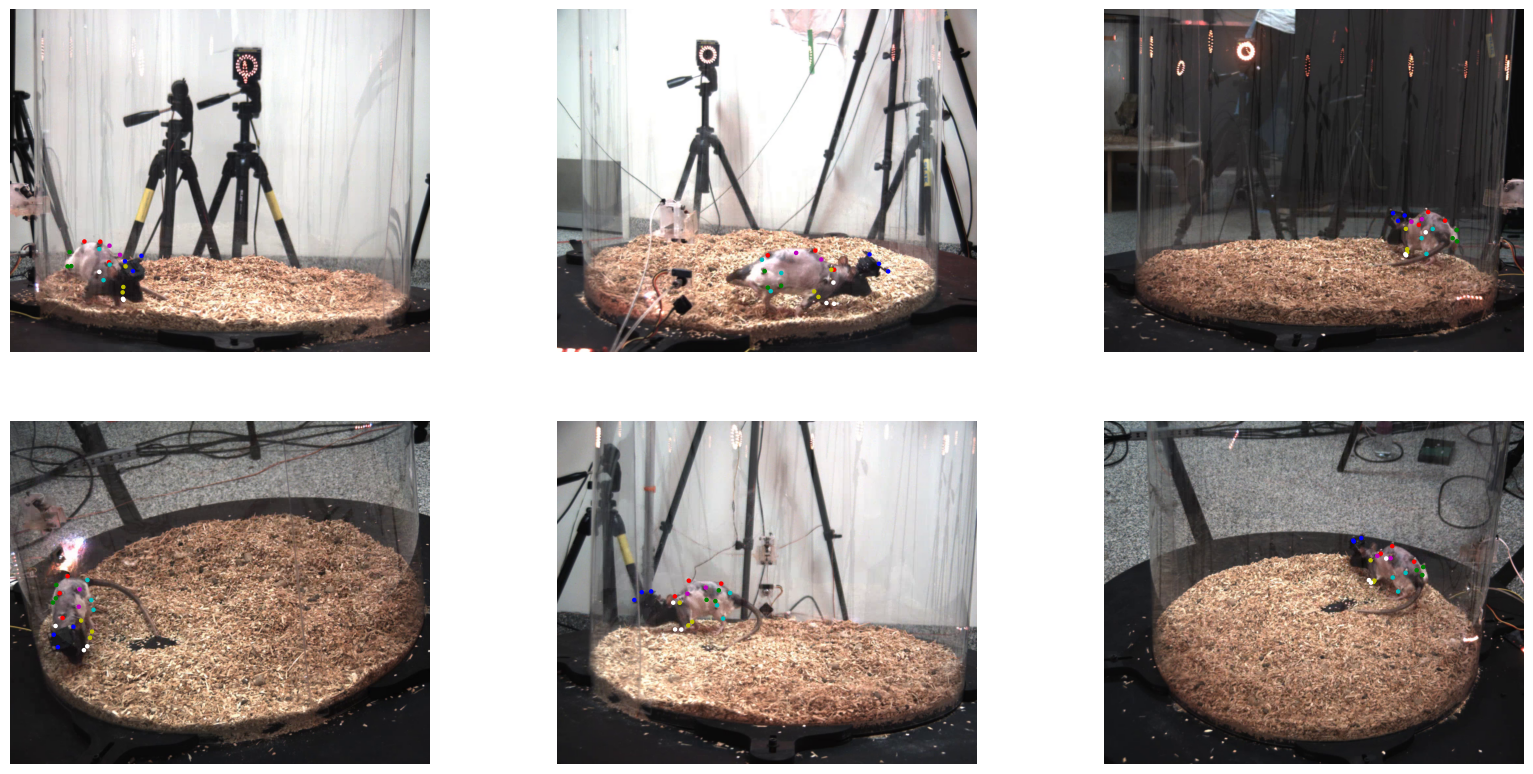

In [153]:
import matplotlib.pyplot as plt
from celluloid import Camera
%matplotlib inline


print(idx)
fig, axs = plt.subplots(nrows=2, ncols=3, dpi=100, figsize=(20,10))
axs = np.ravel(np.array(axs))
for ax in axs:
    ax.axis('off')
cam = Camera(fig)
for frame_id in range(2000):
    #print(frame_id)
    try:
        idx = np.where(mat[0]['data_sampleID'] == frame_id)[0][0]
    except:
        continue
    if os.path.isfile(f'/data/rat7M_e0/sample0_{frame_id}_Camera{cam_list[0]}.png'):
        for cam_id, ax in enumerate(axs):
            ax.imshow(plt.imread(f'/data/rat7M_e0/sample0_{frame_id}_Camera{cam_list[cam_id]}.png'))
            pt = mat[cam_id]['data_2d'][idx].reshape(-1,2)
            ax.scatter(pt[:,0]-20, pt[:,1], c=meta['markercolor'][:20], s=5)
        cam.snap()

cam.animate().save('test_marker.mp4')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'test_3d_gt' is not defined

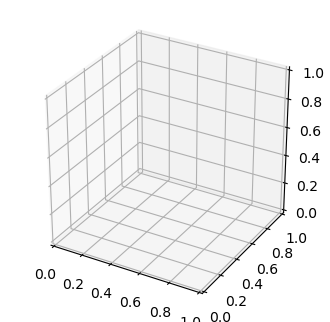

In [38]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

t = 200
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            #pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"],
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False, show_gt_always=False)

for idx, pt in enumerate(test_3d_gt[t]):
    ax.text(pt[0], pt[1], pt[2], str(idx))

origin = test_3d_gt[t][3]
print(origin)
ax.set_xlim([origin[0]-100, origin[0]+100])
ax.set_ylim([origin[1]-50, origin[1]+150])
ax.set_zlim([-40,210])
#ax.set_xlim([-50, 100])

In [37]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
from celluloid import Camera
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

mat = read_data(0, 3)
camera = Camera(fig)
pts3d = mat['data_3d'].reshape(-1,20,3)[0:500]

for i in range(pts3d.shape[0]):        
    plot_pose_3d(ax=ax, tar=pts3d[i],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"], 
            normalize=False)      
    
    origin = pts3d[i][3] if pts3d[i][3] is not None
    ax.set_xbound(origin[0]-100, origin[0]+100)
    ax.set_ylim(origin[1]-50, origin[1]+150)
    ax.set_zlim(-40,160)
    plt.savefig(f'out/test{i}.jpg')
    #camera.snap()
    ax.clear()

camera.animate().save('plot_3d.mp4')

SyntaxError: invalid syntax (<ipython-input-37-bcfb8bb0ec72>, line 22)

In [231]:
!ffmpeg -i ./out/test%d.jpg -pix_fmt yuv420p out.mp4 -y

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/user/anaconda3/envs/lf3d --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Unrecognized option '-yes'.
Error splitting the argument

In [226]:
from IPython.display import Video
Video("plot_3d.mp4")

In [255]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

t = 53
plot_pose_3d(ax=ax, tar=test_3d_gt[t],
             pred=test_3d_pred[t],
            bones=par_data["vis"]["bones"],
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False)

origin = test_3d_gt[t][3] if test_3d_gt[t][3] is not None else [0,0,0]
ax.set_xbound(origin[0]-100, origin[0]+100)
ax.set_ylim(origin[1]-50, origin[1]+150)
ax.set_zlim(25,160)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(25.0, 160.0)

In [1]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)

test_cam_id = [3]
assert len(test_cam_id) == 1
cam = read_cam(session_id, test_cam_id[0])
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

s = test_3d_gt.shape
#test_3d_gt = camera_to_world(test_3d_gt.reshape(s[0], -1), cam['r'].T, cam['t']).reshape(s)
#test_3d_pred = camera_to_world(test_3d_pred.reshape(s[0],-1), cam['r'].T, cam['t']).reshape(s)
#test_3d_pred[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan
test_3d_gt[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan

NameError: name 'torch' is not defined

In [134]:
def plot_pose_2d(frame_id, cam_id, ax):
    #try:
    #    idx = np.where(mat[0]['data_sampleID'] == frame_id)[0][0]
    #except:
    #    return
    idx = mat[0]['data_sampleID'][frame_id][0]
    p = f'/data/rat7M_e0/sample0_{idx}_Camera{cam_list[cam_id]}.png'
    if os.path.isfile(p):
        print('hit')
        try:
            ax.set_data(plt.imread(p))
            return ax
        except:
            return ax.imshow(plt.imread(p))
    else:
        return ax

In [260]:
good_keypts[:,0].sum() / good_keypts[:,0].size

0.631

# increase the image sizes
# varibility in 3d view

# create 2d-3d video

In [4]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)

test_cam_id = [3]
session_id = 0
assert len(test_cam_id) == 1
cam = read_cam(session_id, test_cam_id[0])
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

s = test_3d_gt.shape
test_3d_gt = camera_to_world(test_3d_gt.reshape(s[0], -1), cam['r'].T, cam['t']).reshape(s)
test_3d_pred = camera_to_world(test_3d_pred.reshape(s[0],-1), cam['r'].T, cam['t']).reshape(s)
#test_3d_pred[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan
test_3d_gt[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan

NameError: name 'par' is not defined

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
hit
hit
hit
hit
45
46
47
48
49
50
hit
hit
hit
hit
51
hit
hit
hit
hit
52
hit
hit
hit
hit
53
54
hit
hit
hit
hit
55
56
hit
hit
hit
hit
57
hit
hit
hit
hit
58
59
hit
hit
hit
hit
60
hit
hit
hit
hit
61
62
63
64
65
66
hit
hit
hit
hit
67
68
69
70
hit
hit
hit
hit
71
72
hit
hit
hit
hit
73
74
hit
hit
hit
hit
75
hit
hit
hit
hit
76
77
78
79
hit
hit
hit
hit
80
81
82
83
84
85
86
87
88
hit
hit
hit
hit
89
90
91
92
93
94
95
96
97
98
99


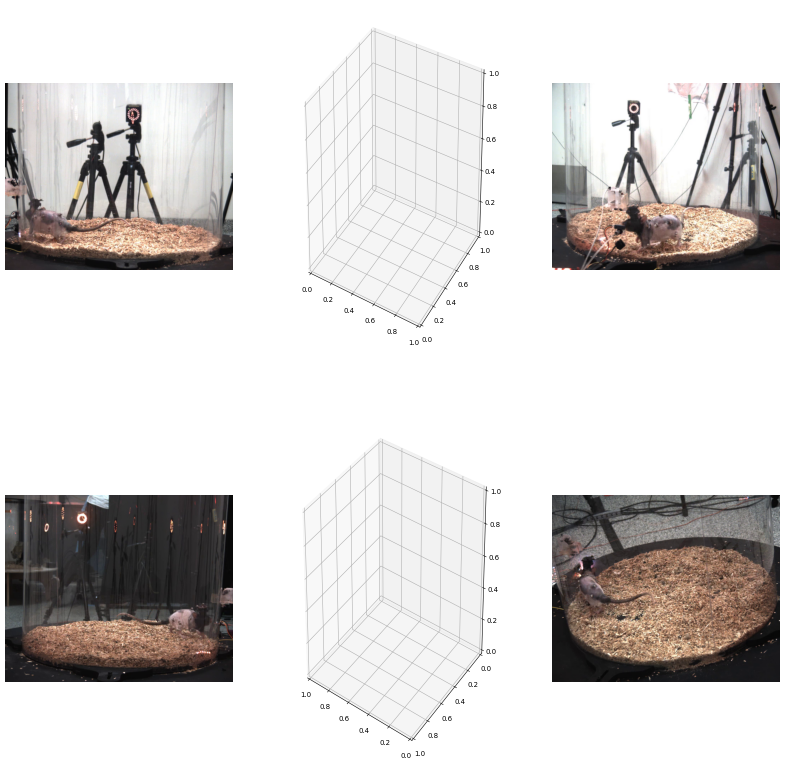

In [251]:
import matplotlib.pyplot as plt
from celluloid import Camera
import numpy as np
from load import read_data
from liftpose.plot import plot_pose_3d
import matplotlib.gridspec as gridspec
%matplotlib inline

session_id = 0
n_frames = 100

mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
fig = plt.figure(figsize=(20,20), dpi=50)

gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])


axs_2d = [fig.add_subplot(231), fig.add_subplot(233), fig.add_subplot(234), fig.add_subplot(236)]
axs_3d = [fig.add_subplot(232, projection='3d'), fig.add_subplot(235, projection='3d')]
axs_3d[1].view_init(30, 125)
axs_2d = np.ravel(np.array(axs_2d))
for ax in axs_2d:
    ax.axis('off')
    
cam = Camera(fig)
for idx, frame_id in enumerate(range(0, 100)):
    print(frame_id)
    for ax2d_idx, ax2d in enumerate(axs_2d):
        axs_2d[ax2d_idx] = plot_pose_2d(frame_id, cam_id=ax2d_idx, ax=ax2d)
    for _, ax3d in enumerate(axs_3d):
        plot_pose_3d(ax=ax3d, tar=test_3d_gt[frame_id].copy(),
                     pred=test_3d_pred[frame_id].copy(),
                     bones=par_data["vis"]["bones"], 
                     limb_id=par_data["vis"]["limb_id"], 
                     colors=par_data["vis"]["colors"], 
                     normalize=False, show_pred_always=True)

        origin = test_3d_gt[frame_id][3] if test_3d_gt[frame_id][3] is not None else [0,0,0]
        ax3d.set_xbound(origin[0]-100, origin[0]+100)
        ax3d.set_ylim(origin[1]-50, origin[1]+150)
        ax3d.set_zlim(25,160)
    
    plt.savefig(f'out_single_animal/im{idx}.jpg')
    for ax3d in axs_3d:
        ax3d.clear()
    #cam.snap()
#cam.animate().save('test_marker.mp4')

In [252]:
!ffmpeg -i out_single_animal/im%d.jpg -pix_fmt yuv420p out.mp4 -y

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/user/anaconda3/envs/lf3d --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from 'out_single_animal/im%d.jpg':
  D

In [253]:
from IPython.display import Video
Video("out.mp4")

# Violin plot

Text(0, 0.5, 'Percentage of body length (%)')

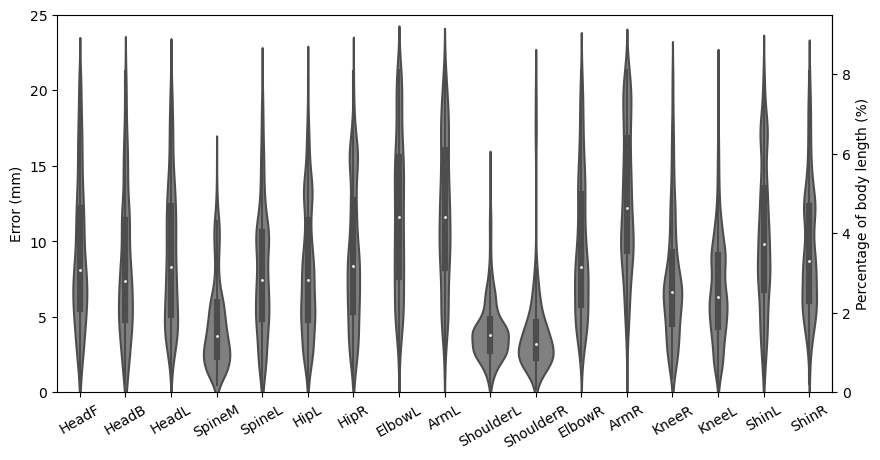

In [285]:
%matplotlib inline
from liftpose.plot import violin_plot
order = ['HeadF', 'HeadB', 'HeadL', 'SpineM', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = par_data["vis"]["names"]
names = [n[0] for n in names]
ax = plt.gca()
violin_plot(ax, test_3d_gt, test_3d_pred, good_keypts, joints_name=names,units='mm', order=order)
plt.ylim([0,25])

y = ax.secondary_yaxis('right', functions=(lambda x: x*100/263.67, lambda x: x*100/263.67))
y.set_ylabel(r'Percentage of body length (%)')

# Missing Joint Prediction

In [ ]:
remove single point, predict again.